In [1]:
################################################
#Building segmentation prediction for each camp#
#Maintainer: Christopher Chan                  #
#Date: 2022-07-15                              #
#Version: 0.2.1                                #
################################################

import os, sys, re
import torch
import PIL
import cv2
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import segmentation_models_pytorch as smp
import rasterio as rio
from scipy import ndimage
from PIL import Image
from torch import optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image
from Networks import Five_UNet, Four_UNet
from dataloader import PredictionDataset
%matplotlib inline

device = (torch.device("cuda") if torch.cuda.is_available()
          else torch.device("cpu"))

print(f"Training on device {device}.")

# ATTENTION, DATASET USE IN THIS IS DIFFERENT FROM TRAIN, VAL, TEST
# THIS HAS NO OVERLAP IN CROPPING IN ORDER TO REPRESENT THE TRUE EXTENT
data_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/ALL_IMG_15cm/IMG")

Training on device cpu.


In [2]:
# Function to load trained weights to appropriate architecture to predict a certain camp

def loading(trained_weights, architecture, camp):
    IMG_ls = []

    if camp == "KBY":
        for root, dirs, filename in os.walk(data_path):
                for f in filename:
                    if (f.startswith("KBY15_IMG")) and (f.endswith(".png")):
                        IMG_ls.append(root + "/" + f)
                        
    elif camp == "DZK":
        for root, dirs, filename in os.walk(data_path):
                for f in filename:
                    if (f.startswith("DZK15_IMG")) and (f.endswith(".png")):
                        IMG_ls.append(root + "/" + f)
    
    elif camp == "DZKN":
        for root, dirs, filename in os.walk(data_path):
                for f in filename:
                    if (f.startswith("DZKN15_IMG")) and (f.endswith(".png")):
                        IMG_ls.append(root + "/" + f)
    
##############################################################

    # Load non-weighted architecture
    if architecture == "EB0-Unet":
        Net = smp.Unet(encoder_name = 'efficientnet-b0', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
        
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        #print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
    
    elif architecture == "EB1-Unet":
        Net = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None) 
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
        
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        #print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
    
        
       
    elif architecture == "qubvel":
        Net = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
        qubvel_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/qubvel_UNet/weights/stage3/effb1-f0/checkpoints/best.pth")
        qubvel_weights = torch.load(qubvel_weights, map_location = device)
        Net.load_state_dict(qubvel_weights["state_dict"])
    
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        #print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)

    elif architecture == "EB2-Unet":
        Net = smp.Unet(encoder_name = 'efficientnet-b2', encoder_depth = 4, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (128, 64, 32, 16), decoder_attention_type = None, in_channels= 3 , classes = 1, activation = "sigmoid", aux_params = None)
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
         
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        #print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
   
    elif architecture == "Four-Unet":
        Net = Four_UNet()
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
        
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        #print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
        
    elif architecture == "Five-Unet":
        Net = Five_UNet()
        
        # Load weights
        weights = os.path.abspath(trained_weights)
        weights = torch.load(weights, map_location = device)
        Net.load_state_dict(weights["Model:"])
        n_params = [p.numel() for p in Net.parameters() if p.requires_grad == True]

        #print(Net)
        print('Trainable parameters in current model:', n_params)
        Net = Net.to(device = device)
        
    print("Selected CNN architecture: {0} to predict camp {1}, which contains {2} images.".format(architecture, camp, len(IMG_ls)))
    
    # Load dataset and predict:
    loader = DataLoader(PredictionDataset(IMG_ls), batch_size = 1, shuffle = False)
    
    pixcount_ls = []
    
    for i, img in tqdm(enumerate(loader), total = len(loader)):
        img = img.to(device = device)
        with torch.no_grad():
            prediction = Net(img)
            prediction = prediction.squeeze(0)
    
            pred_BOOL = (prediction > 0.001).to(torch.float32)
    
            # Booleanise
            pred_BOOL = pred_BOOL.bool()
            pred_IO = pred_BOOL.long().cpu().numpy().squeeze(0)
            
            # List pixcount and img_ls to create new DF
            pixcount_ls.append((pred_IO == 1).sum())
            
            # Change from 16 bit to 8 bit so CV2 can read it
            #pred_IO_8bit = cv2.convertScaleAbs(pred_IO)
            
            # OPTION A: BlobDetector
            
           # Blob detection
            #params = cv2.SimpleBlobDetector_Params()

            # Change thresholds

            #params.minThreshold = 10
            #params.maxThreshold = 200
            ## Filter by Area.
            #params.filterByArea = True
            #params.minArea = 10
            #
            ## Filter by Convexity
            #params.filterByConvexity = True
            #params.minConvexity = 0.87
            ## Filter by Inertia
            #params.filterByInertia = True
            #params.minInertiaRatio = 0.01
            
            #detector = cv2.SimpleBlobDetector_create(params)
            #keypoints = detector.detect(pred_IO_8bit)
            #
            ## Draw detected blobs as red circles
            #blob_w_key = cv2.drawKeypoints(pred_IO_8bit, keypoints, 0, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            #plt.imshow(blob_w_key)
            #
            ## Show keypoints
            #cv2.waitKey(0)
            #
            #outline = cv2.polylines(blob_w_key, keypoints, isClosed = True, color = (0, 0, 255))
            #print(outline.shape)
            #
            #Blob_ls.append(outline)
           
    pixcount_dict = {
        "IMG": IMG_ls,
        "pix_count": pixcount_ls
    }
            
    pixcount_df = pd.DataFrame(pixcount_dict)
    
    for path in pixcount_df["IMG"]:
        pixcount_df["IMG"] = os.path.basename(path)
          
    return img, prediction, pred_BOOL, pixcount_df
     

Trainable parameters in current model: [864, 32, 32, 9216, 32, 32, 18432, 64, 64, 36864, 64, 64, 73728, 128, 128, 147456, 128, 128, 294912, 256, 256, 589824, 256, 256, 1179648, 512, 512, 2359296, 512, 512, 4718592, 1024, 1024, 9437184, 1024, 1024, 2097152, 512, 4718592, 512, 512, 2359296, 512, 512, 524288, 256, 1179648, 256, 256, 589824, 256, 256, 131072, 128, 294912, 128, 128, 147456, 128, 128, 32768, 64, 73728, 64, 64, 36864, 64, 64, 8192, 32, 18432, 32, 32, 9216, 32, 32, 32, 1]
Selected CNN architecture: Five-Unet to predict camp DZKN, which contains 257 images.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 257/257 [36:24<00:00,  8.50s/it]


Text(0.5, 1.0, 'Binary Segmentation')

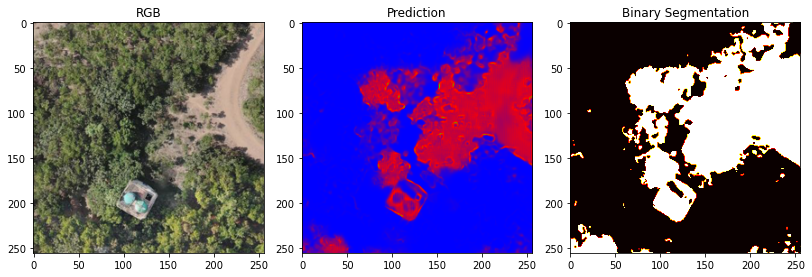

In [3]:
best_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE/best_weights/BASE_15cmALL")

img, prediction, pred_BOOL, pixcount_df = loading(os.path.join(best_weights, "18242:3909_256oc_Five-Unet_lr1e-3_wd1e-5_b32_ep500_BCE_RLRonPlateau(min1e-8)_iter_234680.pth"),
                                                  "Five-Unet", "DZKN")
 
# Plotting the RGB, Prediction, and Confidence
fig = plt.figure(figsize = (15, 6))

ax = fig.add_subplot(1, 4, 1)
fig.tight_layout(w_pad = 3)
#fig.suptitle("256x256(15cm) {0} | {1}".format(camp, trained_weights))
RGB = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(RGB)
ax.set_title('RGB')

ax = fig.add_subplot(1, 4, 2)
PILpred = prediction.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILpred, cmap = "brg")
ax.set_title('Prediction')

ax = fig.add_subplot(1, 4, 3)
PILbin = pred_BOOL.detach().cpu().numpy().transpose(1, 2, 0)
plt.imshow(PILbin, cmap = "hot")
ax.set_title('Binary Segmentation')


In [7]:
pixcount_df

,IMG,pix_count
0,DZKN15_IMG_1280-5632.png,19192
1,DZKN15_IMG_1280-5632.png,19985
2,DZKN15_IMG_1280-5632.png,17359
3,DZKN15_IMG_1280-5632.png,5922
4,DZKN15_IMG_1280-5632.png,20886
...,...,...
252,DZKN15_IMG_1280-5632.png,18885
253,DZKN15_IMG_1280-5632.png,24651
254,DZKN15_IMG_1280-5632.png,21234
255,DZKN15_IMG_1280-5632.png,22710


In [8]:
print(pixcount_df["pix_count"].sum())

5354684


In [9]:
def label_count(camp):

    from PIL import Image, ImageOps

    LBL_ls = []
    pcLBL_ls = []

    if camp == "KBY":
        for root, dirs, filename in os.walk(data_path):
                for f in filename:
                    if (f.startswith("KBY15_IMG")) and (f.endswith(".png")):
                        LBL_ls.append(root + "/" + f)

    elif camp == "DZK":
        for root, dirs, filename in os.walk(data_path):
                for f in filename:
                    if (f.startswith("DZK15_IMG")) and (f.endswith(".png")):
                        LBL_ls.append(root + "/" + f)

    elif camp == "DZKN":
        for root, dirs, filename in os.walk(data_path):
                for f in filename:
                    if (f.startswith("DZKN15_IMG")) and (f.endswith(".png")):
                        LBL_ls.append(root + "/" + f)

    for i in LBL_ls:
        LBL_PIL = Image.open(i)
        LBL_PIL = ImageOps.grayscale(LBL_PIL) 
        LBL_np = np.array(LBL_PIL)
        pcLBL_ls.append((LBL_np == 1).sum())

    return pcLBL_ls


241
231
221
235
170
204
241
228
154
241
245
237
180
244
212
227
242
243
241
240
243
225
208
231
216
231
214
226
238
234
224
216
212
221
198
163
193
244
218
231
227
236
221
237
217
230
235
228
239
233
241
238
241
228
221
240
234
233
240
242
229
227
223
220
194
225
239
235
240
201
242
234
235
204
241
183
238
206
230
187
193
241
235
158
245
226
189
233
235
206
229
242
238
242
229
222
215
231
241
235
208
237
230
245
225
205
232
228
231
230
239
244
208
248
215
228
239
199
244
219
240
240
186
243
237
234
215
217
212
214
180
241
211
216
239
205
235
199
227
215
236
238
241
245
241
233
245
211
243
217
238
223
219
230
243
195
232
236
237
204
234
208
230
235
242
219
225
214
242
195
214
211
199
172
216
241
224
242
238
220
241
218
238
195
243
241
230
230
212
197
235
234
226
193
216
231
239
183
176
208
242
241
236
231
242
237
206
230
219
234
227
245
243
238
236
231
239
233
231
237
237
234
227
237
225
237
240
238
240
197
236
243
209
242
198
237
239
200
240
214
239
226
223
240
197
229
244
210
211
190


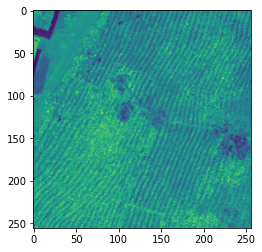

In [21]:
output = label_count("DZK")
print(output)